# 🦠 Sartorius - Starter Torch Mask R-CNN


Following [this discussion thread](https://www.kaggle.com/c/sartorius-cell-instance-segmentation/discussion/279790), in this notebook we build a base starter Mask R-CNN with pytorch.

The code is an adapted version from [this notebook](https://www.kaggle.com/abhishek/mask-rcnn-using-torchvision-0-17/) by the first quadruple kaggle grandmaster [Abishek](https://www.kaggle.com/abhishek).

The [previous U-net model](https://www.kaggle.com/julian3833/sartorius-starter-baseline-torch-u-net), which I was expecting to enter a steep improvement regime with quick-wins, hit a ceiling at `0.03`, no matter what changes I performed 🥲.
Data augmentation, changes in the architecture, and other changes didn't work. The suggestion that semantic segmentation doesn't work seems reasonable, since the individuals cannot be split by connected components, as they overlap heavily.

This is a follow up notebook with a Mask R-CNN, which was proposed by one of the top competitors ([Inoichan](https://www.kaggle.com/inoueu1)) as a more suitable architecture for this task.

I'm not very familiar with the architecture, but it seems that it is the state-of-the art for "instance segmentation".
It classifies individuals, gets bounding boxes around them and, most importantly, provide a separated mask for each of them.

You can read more about it [here](https://viso.ai/deep-learning/mask-r-cnn/).


This model predicts different masks for different individual, rather that an unique mask for the whole picture and thus is better for the address the problem at hand.

At the end, any overlapping pixel is removed, to ensure the non-overlapping policy. That wasn't required with the U-net, since the output was only one unique mask and therefore no overlap could have happened.


## Please _DO_ upvote!


# Imports and constants

In [1]:
import sys
import os
import random
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision.transforms import ToPILImage
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from PIL import Image, ImageFile


# We only use 3 transformations from this package
sys.path.append("../input/maskrcnn-utils/")
from transforms import ToTensor, RandomHorizontalFlip, Compose


def fix_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
fix_all_seeds(2021)

In [2]:
SAMPLE_SUBMISSION  = '../input/sartorius-cell-instance-segmentation/sample_submission.csv'
TRAIN_CSV = "../input/sartorius-cell-instance-segmentation/train.csv"
TRAIN_PATH = "../input/sartorius-cell-instance-segmentation/train"
TEST_PATH = "../input/sartorius-cell-instance-segmentation/test"


NUM_EPOCHS = 12

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Traning Dataset

## Utilities

In [3]:
def rle_decode(mask_rle, shape, color=1):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.float32)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = color
    return img.reshape(shape)


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

## Training Dataset and DataLoader

In [4]:
class CellDataset(Dataset):
    def __init__(self, image_dir, df_path, height, width, transforms=None):
        self.transforms = transforms
        self.image_dir = image_dir
        self.df = pd.read_csv(df_path)
        self.height = height
        self.width = width
        self.image_info = collections.defaultdict(dict)
        temp_df = self.df.groupby('id')['annotation'].agg(lambda x: list(x)).reset_index()
        for index, row in temp_df.iterrows():
            self.image_info[index] = {
                    'image_id': row['id'],
                    'image_path': os.path.join(self.image_dir, row['id'] + '.png'),
                    'annotations': row["annotation"]
                    }
            
    def __getitem__(self, idx):
        # load images ad masks
        img_path = self.image_info[idx]["image_path"]
        img = Image.open(img_path).convert("RGB")
        #img = img.resize((self.width, self.height), resample=Image.BILINEAR)

        info = self.image_info[idx]

        mask = np.zeros((len(info['annotations']), self.width, self.height), dtype=np.uint8)
        labels = []
        
        for m, annotation in enumerate(info['annotations']):
            sub_mask = rle_decode(annotation, (520, 704))
            sub_mask = Image.fromarray(sub_mask)
            #sub_mask = sub_mask.resize((self.width, self.height), resample=Image.BILINEAR)
            sub_mask = np.array(sub_mask) > 0
            mask[m, :, :] = sub_mask
            labels.append(1)

        num_objs = len(labels)
        boxes = []
        new_labels = []
        new_masks = []

        for i in range(num_objs):
            try:
                pos = np.where(mask[i, :, :])
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                boxes.append([xmin, ymin, xmax, ymax])
                new_labels.append(labels[i])
                new_masks.append(mask[i, :, :])
            except ValueError:
                print("Error in xmax xmin")
                pass

        if len(new_labels) == 0:
            boxes.append([0, 0, 20, 20])
            new_labels.append(0)
            new_masks.append(mask[0, :, :])

        nmx = np.zeros((len(new_masks), self.width, self.height), dtype=np.uint8)
        for i, n in enumerate(new_masks):
            nmx[i, :, :] = n

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(new_labels, dtype=torch.int64)
        masks = torch.as_tensor(nmx, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.image_info)

In [5]:
ds_train = CellDataset(TRAIN_PATH, TRAIN_CSV, 704, 520, transforms=get_transform(train=True))

dl_train = DataLoader(ds_train, batch_size=2, shuffle=True, 
                      num_workers=2, collate_fn=lambda x: tuple(zip(*x)))

# Train loop

## Model

In [6]:
# Override pythorch checkpoint with an "offline" version of the file
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp ../input/cocopre/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth

In [7]:
def get_model():
    NUM_CLASSES = 2 # This is just a dummy value for the classification head
    
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, NUM_CLASSES)
    return model


# Get the Mask R-CNN model
# The model does classification, bounding boxes and MASKs for individuals, all at the same time
# We only care about MASKS
model = get_model()
model.to(DEVICE)

for param in model.parameters():
    param.requires_grad = True
    
model.train();

## Training loop!

In [8]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

n_batches = len(dl_train)

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Starting epoch {epoch} of {NUM_EPOCHS}")
    loss_accum = 0.0
    loss_mask_accum = 0.0
    for batch_idx, (images, targets) in enumerate(dl_train, 1):
    
        # Predict
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        loss_value = losses.item()
        loss_mask = loss_dict['loss_mask'].item()
        # 'loss_classifier', 'loss_box_reg':, 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg'
        # print("Losses: ", {k: v.item() for k, v in loss_dict.items()})
        
        # Backprop
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        # Logging
        loss_accum += loss_value
        loss_mask_accum += loss_mask
        if batch_idx % 10 == 0:
            print(f"  [Batch {batch_idx:3d} / {n_batches:3d}] Batch train loss: {loss_value:.3f}. Mask-only loss: {loss_mask:.3f}")
    
    epoch_loss = loss_accum / n_batches
    epoch_mask_loss = loss_mask_accum / n_batches
    print(f"[{epoch:2d} / {NUM_EPOCHS:2d}] Train loss: {epoch_loss:.3f}. Train mask-only loss: {epoch_mask_loss:.3f}")

torch.save(model.state_dict(), "model.bin")

Starting epoch 1 of 12
  [Batch  10 / 303] Batch train loss: 1.641. Mask-only loss: 0.384
  [Batch  20 / 303] Batch train loss: 1.407. Mask-only loss: 0.368
  [Batch  30 / 303] Batch train loss: 2.149. Mask-only loss: 0.423
  [Batch  40 / 303] Batch train loss: 1.746. Mask-only loss: 0.360
  [Batch  50 / 303] Batch train loss: 2.039. Mask-only loss: 0.415
  [Batch  60 / 303] Batch train loss: 1.456. Mask-only loss: 0.277
  [Batch  70 / 303] Batch train loss: 1.503. Mask-only loss: 0.292
  [Batch  80 / 303] Batch train loss: 1.533. Mask-only loss: 0.374
  [Batch  90 / 303] Batch train loss: 1.236. Mask-only loss: 0.257
  [Batch 100 / 303] Batch train loss: 2.058. Mask-only loss: 0.311
  [Batch 110 / 303] Batch train loss: 1.806. Mask-only loss: 0.366
  [Batch 120 / 303] Batch train loss: 1.920. Mask-only loss: 0.434
  [Batch 130 / 303] Batch train loss: 1.801. Mask-only loss: 0.290
  [Batch 140 / 303] Batch train loss: 1.626. Mask-only loss: 0.337
  [Batch 150 / 303] Batch train loss: 1

# Analyze prediction results for train set

In [9]:
def analyze_train_sample(model, ds_train, sample_index):
    img, targets = ds_train[sample_index]
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.title("Image")
    plt.show()
    
    all_masks = np.zeros((520, 704))
    for mask in targets['masks']:
        all_masks = np.logical_or(all_masks, mask)
    plt.imshow(img.numpy().transpose((1,2,0)))
    plt.imshow(all_masks, alpha=0.3)
    plt.title("Ground truth")
    plt.show()
    
    model.eval()
    with torch.no_grad():
        preds = model([img.to(DEVICE)])[0]

    plt.imshow(img.cpu().numpy().transpose((1,2,0)))
    all_preds_masks = np.zeros((520, 704))
    for mask in preds['masks'].cpu().detach().numpy():
        all_preds_masks = np.logical_or(all_preds_masks, mask[0])
    plt.imshow(all_preds_masks, alpha=0.4)
    plt.title("Predictions")
    plt.show()

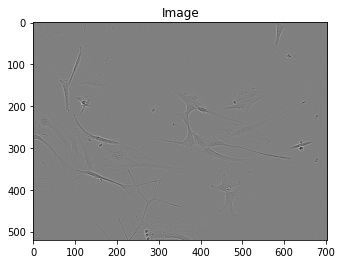

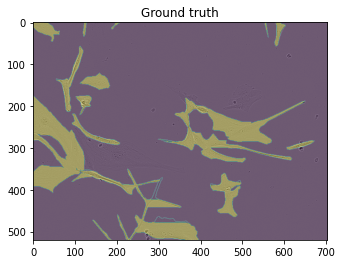

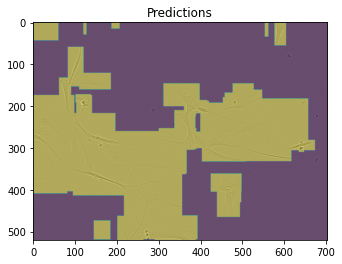

In [10]:
# NOTE: It puts the model in eval mode!! Revert for re-training
analyze_train_sample(model, ds_train, 20)

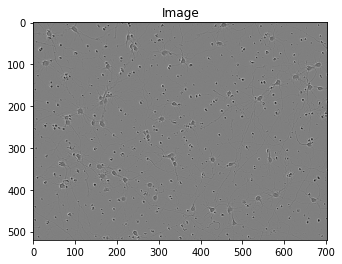

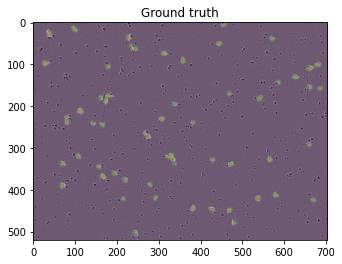

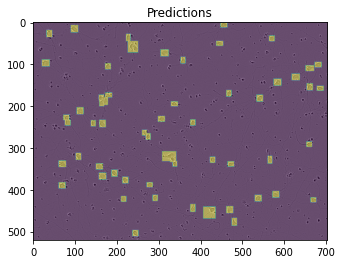

In [11]:
analyze_train_sample(model, ds_train, 100)

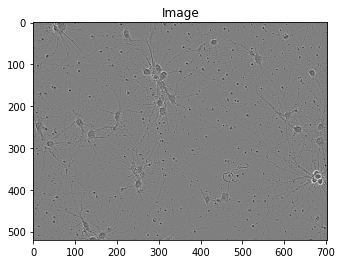

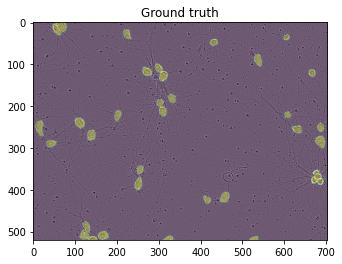

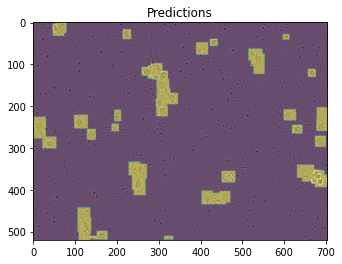

In [12]:
analyze_train_sample(model, ds_train, 2)

# Prediction

## Test Dataset and DataLoader

In [13]:
class CellTestDataset(Dataset):
    def __init__(self, image_dir, height, width, transforms=None):
        self.transforms = transforms
        
        self.image_dir = image_dir
        
        self.image_ids = [f[:-4]for f in os.listdir(self.image_dir)]
        self.num_samples = len(self.image_ids)
        
        self.height = height
        self.width = width
        self.image_info = collections.defaultdict(dict)
            
    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.image_dir, image_id + '.png')
        image = Image.open(image_path).convert("RGB")
        #image = image.resize((self.width, self.height), resample=Image.BILINEAR)

        if self.transforms is not None:
            image, _ = self.transforms(image=image, target=None)
        return {'image': image, 'image_id': image_id}

    def __len__(self):
        return len(self.image_ids)

In [14]:
ds_test = CellTestDataset(TEST_PATH, 704, 520, transforms=get_transform(train=False))
ds_test[0]

{'image': tensor([[[0.5020, 0.5020, 0.4980,  ..., 0.4980, 0.4941, 0.4902],
          [0.5020, 0.5020, 0.4941,  ..., 0.5020, 0.5020, 0.5020],
          [0.5098, 0.5098, 0.5020,  ..., 0.5137, 0.5020, 0.5137],
          ...,
          [0.4980, 0.4980, 0.4980,  ..., 0.5333, 0.5216, 0.5176],
          [0.5098, 0.5098, 0.5098,  ..., 0.5373, 0.5451, 0.5373],
          [0.4941, 0.5059, 0.5020,  ..., 0.5686, 0.5569, 0.5490]],
 
         [[0.5020, 0.5020, 0.4980,  ..., 0.4980, 0.4941, 0.4902],
          [0.5020, 0.5020, 0.4941,  ..., 0.5020, 0.5020, 0.5020],
          [0.5098, 0.5098, 0.5020,  ..., 0.5137, 0.5020, 0.5137],
          ...,
          [0.4980, 0.4980, 0.4980,  ..., 0.5333, 0.5216, 0.5176],
          [0.5098, 0.5098, 0.5098,  ..., 0.5373, 0.5451, 0.5373],
          [0.4941, 0.5059, 0.5020,  ..., 0.5686, 0.5569, 0.5490]],
 
         [[0.5020, 0.5020, 0.4980,  ..., 0.4980, 0.4941, 0.4902],
          [0.5020, 0.5020, 0.4941,  ..., 0.5020, 0.5020, 0.5020],
          [0.5098, 0.5098, 0.50

## Utilities

In [15]:
# Stolen from: https://www.kaggle.com/arunamenon/cell-instance-segmentation-unet-eda
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# Modified by me
def rle_encoding(x):
    dots = np.where(x.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join(map(str, run_lengths))


def does_overlap(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            #import pdb; pdb.set_trace()
            #print("Found overlapping masks!")
            return True
    return False


def remove_overlapping_pixels(mask, other_masks):
    for other_mask in other_masks:
        if np.sum(np.logical_and(mask, other_mask)) > 0:
            mask[np.logical_and(mask, other_mask)] = 0
    return mask

## Submission

In [16]:
DROP_OVERLAPPING = False

sublist = []
counter = 0

width = 704
height = 520
THRESHOLD = 0.5

model.eval()

for sample in ds_test:
    img = sample['image']
    image_id = sample['image_id']
    with torch.no_grad():
        result = model([img.to(DEVICE)])[0]
    if len(result["masks"]) > 0:
        previous_masks = []
        for j, m in enumerate(result["masks"]):
            original_mask = result["masks"][j][0].cpu().numpy()
            if DROP_OVERLAPPING and does_overlap(original_mask, previous_masks):
                continue
            else:
                original_mask = remove_overlapping_pixels(original_mask, previous_masks)
                previous_masks.append(original_mask)
                #img_mask = ToPILImage()(original_mask)
                #mask = np.asarray(img_mask.resize((width, height), resample=Image.BILINEAR))
                rle = rle_encoding(original_mask > THRESHOLD)
                sublist.append([image_id, rle])
    else:
        sublist.append([image_id, ""])

df_sub = pd.DataFrame(sublist, columns=['id', 'predicted'])
df_sub.to_csv("submission.csv", index=False)
df_sub.head()

,id,predicted
0,7ae19de7bc2a,149632 10 150335 12 151038 14 151740 17 152443...
1,7ae19de7bc2a,140002 19 140706 21 141410 21 142114 21 142818...
2,7ae19de7bc2a,207960 9 208663 10 209366 11 210069 12 210773 ...
3,7ae19de7bc2a,140245 6 140948 8 141652 8 142356 9 143060 9 1...
4,7ae19de7bc2a,96418 5 97121 7 97825 8 98529 8 99233 9 99937 ...
